# import packages

In [1]:
import numpy as np
import os, glob
from netCDF4 import Dataset
import xarray, wrf
from pandas import to_datetime
from scipy.signal import welch
from scipy import fftpack
from matplotlib.cm import get_cmap
import cartopy.crs as crs
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [2]:
fs=14
plt.rc("font",size=fs)

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# define parameters

In [4]:
height = 100.0

In [5]:
dx = {"MYNN":333.0,
       "SH":333.0,
       "VLES":333.0,
       "YSU":333.0,
       "LES_25":25.0}

In [6]:
colors = {25:'k',333:'r'}
colors = {"LES_25":"k","MYNN":"#FFC300","SH":"#FF5733","YSU":"#C70039","VLES":"#900C3F"}

In [7]:
figPath = "/glade/u/home/doubrawa/figs/"

### define a time

In [8]:
year     = 2015
month    = 3

In [10]:
for day in [28]:
    directories = {"MYNN":"/glade/scratch/doubrawa/final_data/mynn/03{0}15/".format(day),
                   "SH":"/glade/scratch/doubrawa/final_data/sh/03{0}15/".format(day),
                   "VLES":"/glade/scratch/doubrawa/final_data/vles/03{0}15/".format(day),
                   "YSU":"/glade/scratch/doubrawa/final_data/ysu/03{0}15/".format(day),
                   "LES_25":"/glade/scratch/doubrawa/post_processing/"}    
    for hour in [17]:#np.arange(14,24,1)
        minutes = [30]#np.arange(0,59,10) if hour!=14 else np.arange(20,59,10)
        for minute in minutes:
            datetime = to_datetime("{0}-{1}-{2} {3}:{4}".format(year,month,day,hour,minute),format="%Y-%m-%d %H:%M")
            print("-----------------------")
            print(datetime)
            
            w     = {}
            ws    = {}
            u     = {}
            v     = {}
            theta = {}
            xlat  = {}
            xlong = {}
            
            for key,directory in directories.items():
                
                if "LES_" not in key:
                    wrfouts = sorted(glob.glob(os.path.join(directory,'wrfout_d03_2015-03-{0}_{1}:{2:02d}*'.format(day,hour,minute))))
                    wrfout  = wrfouts[0]
                    print (os.path.split(wrfout)[-1])

                    wrfnc = Dataset(wrfout)
                    hgt   = wrf.getvar(wrfnc, "ter", units="m")
                    z     = wrf.getvar(wrfnc, "z", units="m")
                    zref  = z-hgt

                    w_3d   = wrf.getvar(wrfnc, "wa", units="m s-1", timeidx=0)
                    w[key] = wrf.interplevel(w_3d, zref, height, meta=True)                       
                    
                    theta_3d   = wrf.getvar(wrfnc, "theta", units="K", timeidx=0)
                    theta[key] = wrf.interplevel(theta_3d, zref, height, meta=True)                       

                    xlat[key]  = wrf.getvar(wrfnc, "lat")
                    xlong[key] = wrf.getvar(wrfnc, "lon")
                    
                    ua = wrf.getvar(wrfnc,"ua", timeidx=0)
                    va = wrf.getvar(wrfnc,"va", timeidx=0)
                    u[key] = wrf.interplevel(ua, zref, height, meta=True)
                    v[key] = wrf.interplevel(va, zref, height, meta=True)
                    ws[key] = (u[key]**2+v[key]**2)**0.5                    

                else:                    
                    wrfouts = sorted(glob.glob(os.path.join(directory,'WRF_LES_25m_{0}*2015-03-{1}_{2}:{3:02d}*'.format(height,day,hour,minute))))
                    wrfout  = wrfouts[0]
                    print (os.path.split(wrfout)[-1])                
                    
                    wrfnc = xarray.open_dataset(wrfout)
                    w[key] = wrfnc["w"]
                    theta[key] = wrfnc["theta"]
                    u[key] = wrfnc['u']
                    v[key] = wrfnc['v']
                    ws[key] = (wrfnc['u']**2+wrfnc['v']**2)**0.5
                    xlat[key]  = wrfnc["lat"]
                    xlong[key] = wrfnc["lon"]


            # equivalent x/y coordinates across domains

            x = {}
            y = {}

            ref_wrfnc = Dataset("/glade/scratch/doubrawa/final_data/les/032815/032815_14UTC/wrfout_d04_2015-03-28_14:00:00_0000")

            for key in directories.keys():
                print (key)
                x[key], y[key] = wrf.ll_to_xy(ref_wrfnc, xlat[key], xlong[key])
                x[key]   = np.reshape(x[key].data,w[key].shape)
                y[key]   = np.reshape(y[key].data,w[key].shape)

            # clip all of them to the same area

            xmin, xmax = np.min(x["LES_25"]), np.max(x["LES_25"])
            ymin, ymax = np.min(y["LES_25"]), np.max(y["LES_25"])

            x_clipped     = {}
            y_clipped     = {}
            w_clipped     = {}
            u_clipped     = {}
            v_clipped     = {}
            theta_clipped = {}
            ws_clipped    = {}

            for key in ["MYNN","SH","YSU","VLES"]:

                condition_x = ( (x[key] >= xmin) & (x[key]<=xmax) )
                condition_y = ( (y[key] >= ymin) & (y[key]<=ymax) )
                condition   = condition_x & condition_y

                idx_sn, idx_we = np.where(condition)
                idx_sn = np.unique(idx_sn)
                idx_we = np.unique(idx_we)

                w_clipped[key] = (w[key].isel(west_east=idx_we,south_north=idx_sn)).copy()
                u_clipped[key] = (u[key].isel(west_east=idx_we,south_north=idx_sn)).copy()
                v_clipped[key] = (v[key].isel(west_east=idx_we,south_north=idx_sn)).copy()    
                ws_clipped[key] = (ws[key].isel(west_east=idx_we,south_north=idx_sn)).copy()
                theta_clipped[key] = (theta[key].isel(west_east=idx_we,south_north=idx_sn)).copy()
                x_clipped[key] = (x[key][idx_sn,idx_we]).copy()
                y_clipped[key] = (y[key][idx_sn,idx_we]).copy()

            x_clipped["LES_25"] = x["LES_25"]
            y_clipped["LES_25"] = y["LES_25"]
            w_clipped["LES_25"] = w["LES_25"]
            u_clipped["LES_25"] = u["LES_25"]
            v_clipped["LES_25"] = v["LES_25"]
            theta_clipped["LES_25"] = theta["LES_25"]
            ws_clipped["LES_25"] = ws["LES_25"]            

-----------------------
2015-03-28 17:30:00
wrfout_d03_2015-03-28_17:30:00
wrfout_d03_2015-03-28_17:30:00
wrfout_d03_2015-03-28_17:30:00
wrfout_d03_2015-03-28_17:30:00
WRF_LES_25m_100.0_m_AGL_2015-03-28_17:30.nc
MYNN
SH
VLES
YSU
LES_25


# Check different cut-off filter wavelengths

In [11]:
v_array = w_clipped

In [12]:
# for i in range(1,7,1):
#     filter_meters = 333.*i

#     kappa_cut = 1/float(filter_meters)

#     psd_2d      = {}
#     kappas_1d   = {}
#     kappas_x_2d = {}
#     kappas_y_2d = {}

#     for key in w.keys():
#         psd_2d[key]                   = fftpack.fft2(v_array[key])
#         kappas_1d[key]                = fftpack.fftfreq(len(np.squeeze(v_array[key])),d=dx[key])
#         [kappas_x_2d[key],kappas_y_2d[key]] = np.meshgrid(kappas_1d[key],kappas_1d[key])       

#     psd_2d_filt = {}

#     for key in w.keys():
#         print (key)
#         idx     = np.where( (np.abs(kappas_x_2d[key])>kappa_cut) | (np.abs(kappas_y_2d[key])>kappa_cut) )
#         psd_2d_filt[key] = np.squeeze(psd_2d[key]).copy()
#         psd_2d_filt[key][idx] = 0.0+0j

#     v_array_filt = {}
#     for key in w.keys():
#         v_array_filt[key] = fftpack.ifft2(psd_2d_filt[key])

#     levels = np.arange(-1.0,1.1,0.1)

#     keys  = ["LES_25","VLES","SH","YSU","MYNN"]
#     nkeys = len(keys)

#     fig = plt.figure(figsize=(20,30))
#     ax  = {}

#     iax = 1
#     for ikey,key in enumerate(["LES_25","VLES","MYNN","YSU","SH"]):

#         if iax==1:
#             ax[iax] = fig.add_subplot(2*nkeys,2,iax,aspect='equal')
#         else:
#             ax[iax] = fig.add_subplot(2*nkeys,2,iax,sharex=ax[1],sharey=ax[1],aspect='equal')
#         ax[iax].set_title(key) 

#         ax[iax].contourf( np.squeeze(x_clipped[key]), 
#                           np.squeeze(y_clipped[key]), 
#                           np.squeeze(v_array[key]),
#                           levels=levels,
#                           cmap="RdBu")

#         if (iax<(nkeys*2-1)):
#             plt.setp(ax[iax].get_xticklabels(), visible=False)    

#         iax += 1

#         ax[iax] = fig.add_subplot(2*nkeys,2,iax,sharex=ax[1],sharey=ax[1],aspect='equal')
#         ax[iax].set_title(key+" + sharp filter")

#         ax[iax].contourf( np.squeeze(x_clipped[key]), 
#                           np.squeeze(y_clipped[key]), 
#                           np.squeeze(v_array_filt[key]),
#                          levels=levels,
#                          cmap="RdBu")       

#         if np.mod(iax,2.)==0:
#             plt.setp(ax[iax].get_yticklabels(), visible=False)
#         if (iax<(nkeys*2-1)):
#             plt.setp(ax[iax].get_xticklabels(), visible=False)    

#         iax += 1

#     fig.suptitle("$\kappa_{{cut}}\sim$1/({0:.0f} m)".format(filter_meters),y=0.9)
#     fig.subplots_adjust(wspace=0.2)
#     fname = os.path.join(figPath,"contours_w_clipped_and_filtered_{0:%Y-%m-%d-%H-%M}_{1:.0f}m_kappa_{2:.0f}m.png".format(datetime,height,filter_meters))
#     print(fname)
#     fig.savefig(fname,bbox_to_inches="tight")    

# do the actual filtering

In [13]:
filter_meters = 333.*6

kappa_cut = 1/float(filter_meters)

psd_2d      = {}
kappas_1d   = {}
kappas_x_2d = {}
kappas_y_2d = {}

for key in w.keys():
    psd_2d[key]                   = fftpack.fft2(v_array[key])
    kappas_1d[key]                = fftpack.fftfreq(len(np.squeeze(v_array[key])),d=dx[key])
    [kappas_x_2d[key],kappas_y_2d[key]] = np.meshgrid(kappas_1d[key],kappas_1d[key])       

psd_2d_filt = {}

for key in w.keys():
    print (key)
    idx     = np.where( (np.abs(kappas_x_2d[key])>kappa_cut) | (np.abs(kappas_y_2d[key])>kappa_cut) )
    psd_2d_filt[key] = np.squeeze(psd_2d[key]).copy()
    psd_2d_filt[key][idx] = 0.0+0j

v_array_filt = {}
for key in w.keys():
    v_array_filt[key] = fftpack.ifft2(psd_2d_filt[key])

MYNN
SH
VLES
YSU
LES_25


# filter again, in a different way

In [ ]:
p = ax.contourf(np.sort(k),
                np.sort(k),
                np.log10(fftpack.fftshift(np.abs(psd))),
                levels=np.arange(0,4.1,0.5));

In [24]:
filter_meters = 333.*3

kappa_cut = 1/float(filter_meters)

psd_2d_2      = {}
kappas_1d_2   = {}
kappas_x_2d_2 = {}
kappas_y_2d_2 = {}

for key in w.keys():
    psd_2d_2[key]                       = fftpack.fft2(v_array[key])
    psd_2d_2[key]                       = fftpack.fftshift(psd_2d_2[key])
    kappas_1d_2[key]                    = fftpack.fftfreq(len(np.squeeze(v_array[key])),d=dx[key])
    sorted_kappas_1d = np.sort(kappas_1d_2[key])
    [kappas_x_2d_2[key],kappas_y_2d_2[key]] = np.meshgrid(sorted_kappas_1d,sorted_kappas_1d)       

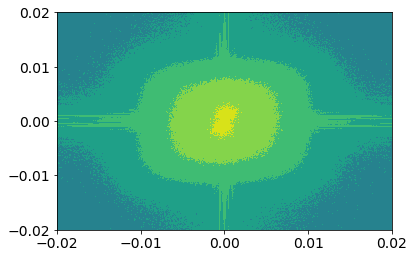

In [25]:
plt.figure()
plt.contourf(kappas_x_2d_2[key], kappas_y_2d_2[key], np.squeeze(np.log10(psd_2d_2[key])))

In [26]:
psd_2d_filt_2 = {}

for key in w.keys():
    print (key)
    idx     = np.where( (np.abs(kappas_x_2d_2[key])>kappa_cut) | (np.abs(kappas_y_2d_2[key])>kappa_cut) )
    psd_2d_filt_2[key] = np.squeeze(psd_2d_2[key]).copy()
    psd_2d_filt_2[key][idx] = 0.0+0j

MYNN
SH
VLES
YSU
LES_25


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


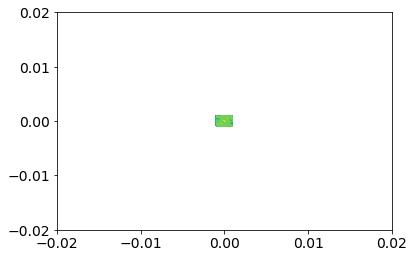

In [27]:
plt.figure()
plt.contourf(kappas_x_2d_2[key], kappas_y_2d_2[key], np.squeeze(np.log10(psd_2d_filt_2[key])))

In [50]:
xx         = np.squeeze(v_array[key])
ff         = fftpack.fftfreq(len(xx),d=dx[key])
psd        = fftpack.fft2(xx)
psd        = fftpack.fftshift(psd)
psd[np.where(np.abs(psd)==0)] = np.nan
psd_mean   = np.mean(np.abs(psd),axis=0)

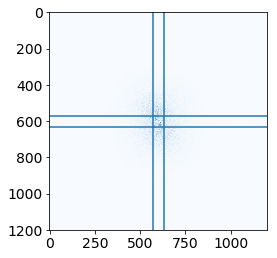

In [79]:
plt.imshow(np.abs(psd),cmap='Blues')
plt.axhline(y=570)
plt.axhline(y=630)
plt.axvline(x=570)
plt.axvline(x=630)

In [104]:
xxf        = np.squeeze(v_array_filt_2[key])
fff        = fftpack.fftfreq(len(xxf),d=dx[key])
psdf       = fftpack.fft2(xxf)
# psdf       = fftpack.fftshift(psdf)
# psdf[np.where(np.abs(psdf)<1e-10)] = np.nan
psd_meanf  = np.mean(np.abs(psdf),axis=0)

In [75]:
not_nan_rows, not_nan_cols = np.where(~(np.isnan(np.abs(psdf))))

In [77]:
np.unique(not_nan_rows)

array([570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582,
       583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595,
       596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608,
       609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621,
       622, 623, 624, 625, 626, 627, 628, 629, 630])

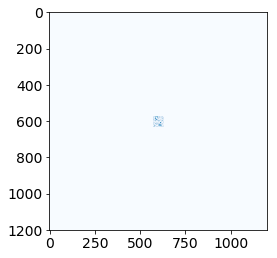

In [105]:
plt.imshow(np.abs(psdf),cmap='Blues')

In [80]:
psdcp = psd.copy()

In [98]:
psdcp[:,:]=np.nan

In [99]:
# psdcp[570:630+1,570:630+1]=psd[570:630+1,570:630+1]
# # psdcp[:,570:630+1]=psd[:,570:630+1]

In [100]:
psdcp[570:630+1,:]=psd[570:630+1,:]
# psdcp[:,570:630+1]=psd[:,570:630+1]

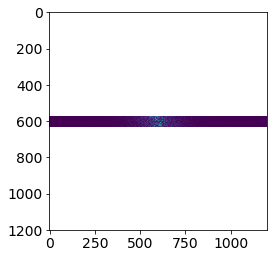

In [107]:
plt.imshow(np.abs(psdcp))

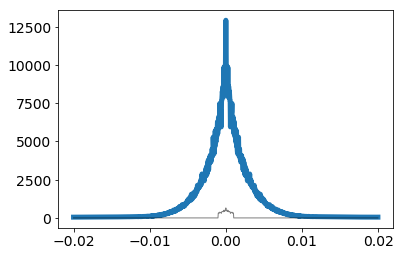

In [108]:
plt.plot(np.sort(fff),np.nanmean(np.abs(psdcp),axis=0),lw=5)
plt.plot(np.sort(fff),np.nanmean(np.abs(psdf),axis=0),'-k',lw=1,alpha=0.5)

In [28]:
v_array_filt_2 = {}
for key in w.keys():
    v_array_filt_2[key] = fftpack.ifft2(psd_2d_filt_2[key])

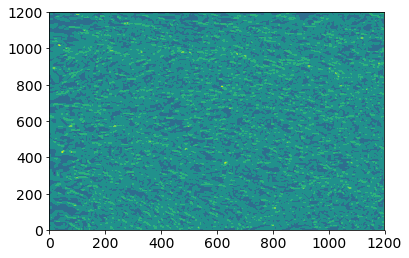

In [30]:
plt.figure()
plt.contourf(np.squeeze(v_array[key]))

/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/numpy/ma/core.py:2785: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


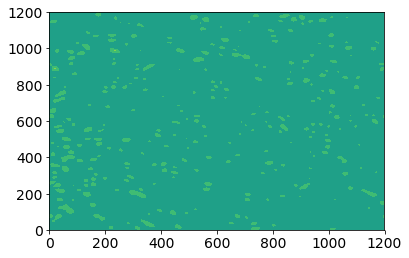

In [31]:
plt.figure()
plt.contourf(np.squeeze(v_array_filt_2[key]))

# sanity check

In [264]:
key = "LES_25"

In [266]:
# plt.figure()
# plt.contourf(np.sort(kappas_1d[key]), 
#              np.sort(kappas_1d[key]), 
#              np.log10(np.abs(fftpack.fftshift(psd_before))),
#              levels=np.arange(-2,5.1,1))

# psd_before = np.squeeze(psd_2d_filt[key])
# psd_after  = np.squeeze(fftpack.fft2(np.squeeze(v_array_filt[key])))

# print(np.sum(np.abs(psd_after-psd_before)))

# plt.figure()
# plt.contourf(np.sort(kappas_1d[key]), 
#              np.sort(kappas_1d[key]), 
#              np.log10(np.abs(fftpack.fftshift(psd_after))),
#              levels=np.arange(-2,5.1,1))

In [267]:
def make_axbig(fig,xlabel,ylabel,title):
    axbig = fig.add_subplot(111)
    axbig.spines['top'].set_color('none')
    axbig.spines['bottom'].set_color('none')
    axbig.spines['left'].set_color('none')
    axbig.spines['right'].set_color('none')
    axbig.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    axbig.set_xlabel(xlabel,labelpad=5)
    axbig.set_ylabel(ylabel,labelpad=10)
    axbig.set_title(title,y=1.1)    
    return axbig

/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log10
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in log10
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in log10


LES_25
1.8433920679516933e-07
MYNN
0.03300281
SH
0.03022054
YSU
0.018758759
VLES
0.04532497
/glade/u/home/doubrawa/figs/PSD_1d_w_along_west_east_2015-03-28-17-30_100m_kappa_1332m.png


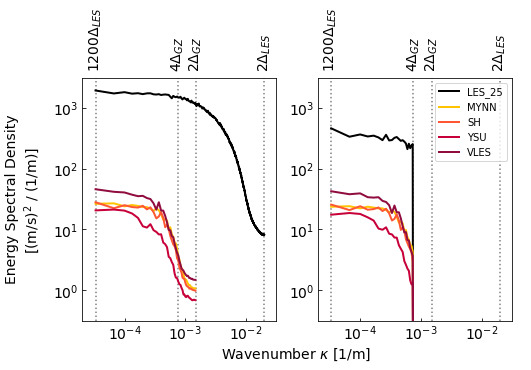

In [288]:
#
# along west_east direction
#

segment = 30000

fig   = plt.figure(figsize=(8,5))
axbig = make_axbig(fig, xlabel="Wavenumber $\kappa$ [1/m] ", ylabel="Energy Spectral Density\n[(m/s)$^{{2}}$ / (1/m)] ", title=" ")

var = w_clipped
var_filt = v_array_filt

ax1  = fig.add_subplot(1,2,1,aspect='equal')

ax1.axvline(x=np.log10(1/666.0),color='gray',linestyle=":")
ax1.axvline(x=np.log10(1/50.0),color='gray',linestyle=":")
ax1.axvline(x=np.log10(1/segment), color='gray',linestyle=":")
ax1.axvline(x=np.log10(kappa_cut), color='gray',linestyle=":")   

for key in ["LES_25","MYNN","SH","YSU","VLES"]:

    xx    = np.squeeze(var[key])
    ff    = fftpack.fftfreq(len(xx),d=dx[key])
    psd   = np.mean(np.abs(fftpack.fft2(xx)),axis=0)
    label = "$\Delta={0:.0f}$ m ({1})".format(dx[key],key)     
    
    ax1.plot(np.log10(ff),np.log10(psd),lw=2,label=label,color=colors[key])   

    ax1.set_ylim([-0.5, 3.5])
    ax1.set_xlim([-4.7,-1.5])
    
# ref_f     = np.linspace(4e-3,2e-2,20)
# ref_slope = ref_f**(-5/3) * 5e-1
# ax1.plot(np.log10(ref_f),np.log10(ref_slope),'--k',lw=2)
# ax1.text(-2,3,'$\propto f^{{-5/3}}$',horizontalalignment='left') 

ax1.set_xticks([-4,-3,-2])
ax1.set_xticklabels(["$10^{{-4}}$","$10^{{-3}}$","$10^{{-2}}$"])
ax1.text(np.log10(1/666.),3.6,"2$\Delta_{{GZ}}$",ha='center',va='bottom',rotation=90)
ax1.text(np.log10(1/50.),3.6,"2$\Delta_{{LES}}$",ha='center',va='bottom',rotation=90)
ax1.text(np.log10(1/segment),3.6,"1200$\Delta_{{LES}}$",ha='center',va='bottom',rotation=90)
ndxgz=int((1/kappa_cut)/333.)
ax1.text(np.log10(kappa_cut),3.6,"{0}$\Delta_{{GZ}}$".format(ndxgz),ha='center',va='bottom',rotation=90)

yticks = [0,1,2,3]
ax1.set_yticks(yticks)
ax1.set_yticklabels(["$10^{{{0}}}$".format(i) for i in yticks])

ax1.xaxis.set_tick_params(direction='in')
ax1.yaxis.set_tick_params(direction='in')   

ax2 = fig.add_subplot(1,2,2,sharex=ax[0],sharey=ax[0],aspect='equal')

ax2.axvline(x=np.log10(1/segment), color='gray',linestyle=":")
ax2.axvline(x=np.log10(kappa_cut), color='gray',linestyle=":")    
ax2.axvline(x=np.log10(1/666.0),color='gray',linestyle=":")
ax2.axvline(x=np.log10(1/50.0),color='gray',linestyle=":")    

for key in ["LES_25","MYNN","SH","YSU","VLES"]:

    print (key)
    nseg = segment/float(dx[key])
    
    psd_before = np.squeeze(psd_2d_filt[key])
    
    xx         = np.squeeze(var_filt[key])
    ff         = fftpack.fftfreq(len(xx),d=dx[key])
    psd        = fftpack.fft2(xx)
    psd_mean   = np.mean(np.abs(psd),axis=0)
    
    print (np.sum(np.abs(psd-psd_before)))    
    
    ax2.plot(np.log10(ff),np.log10(psd_mean),lw=2,label=key,color=colors[key])       

ax2.set_xticks([-4,-3,-2])
ax2.set_xticklabels(["$10^{{-4}}$","$10^{{-3}}$","$10^{{-2}}$"])
ax2.text(np.log10(1/666.),3.6,"2$\Delta_{{GZ}}$",ha='center',va='bottom',rotation=90)
ax2.text(np.log10(1/50.),3.6,"2$\Delta_{{LES}}$",ha='center',va='bottom',rotation=90)
ndxgz=int((1/kappa_cut)/333.)
ax2.text(np.log10(kappa_cut),3.6,"{0}$\Delta_{{GZ}}$".format(ndxgz),ha='center',va='bottom',rotation=90)
ax2.text(np.log10(1/segment),3.6,"1200$\Delta_{{LES}}$",ha='center',va='bottom',rotation=90)    
    
ax2.xaxis.set_tick_params(direction='in')
ax2.yaxis.set_tick_params(direction='in')       

ax2.set_yticks(yticks)
ax2.set_yticklabels(["$10^{{{0}}}$".format(i) for i in yticks])

plt.legend(loc='best',fontsize=10)    
    
fname = os.path.join(figPath,"PSD_1d_w_along_west_east_{0:%Y-%m-%d-%H-%M}_{1:.0f}m_kappa_{2:.0f}m.png".format(datetime,height,filter_meters))    
print(fname)
fig.subplots_adjust(left=0.15,top=0.80)
fig.savefig(fname,bbox_to_inches="tight",dpi=300)

/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log10
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in log10


LES_25
MYNN
SH
YSU
VLES
/glade/u/home/doubrawa/figs/PSD_1d_w_along_west_east_2015-03-28-17-30_100m_kappa_1332m.png


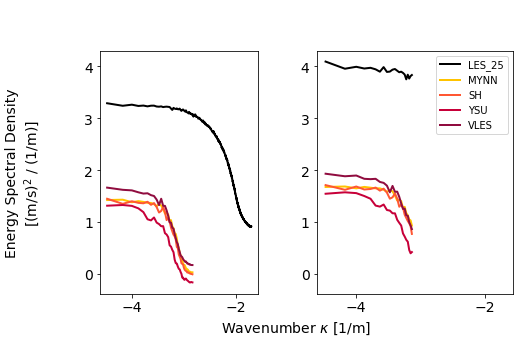

In [310]:
#
# along west_east direction
#

segment = 30000

fig   = plt.figure(figsize=(8,5))
axbig = make_axbig(fig, xlabel="Wavenumber $\kappa$ [1/m] ", ylabel="Energy Spectral Density\n[(m/s)$^{{2}}$ / (1/m)] ", title=" ")

var = w_clipped
var_filt = v_array_filt

ax1  = fig.add_subplot(1,2,1,aspect='equal') 

for key in ["LES_25","MYNN","SH","YSU","VLES"]:

    xx    = np.squeeze(var[key])
    
    a = np.squeeze(np.abs(np.squeeze(psd_2d[key])))
    b = a.copy()
    idxnan = np.where(a<=1e-5)
    b[idxnan]=np.nan
    
    ff         = fftpack.fftfreq(len(b),d=dx[key])    
    psd_mean = np.nanmean(b,axis=0)

    ax1.plot(np.log10(ff),np.log10(psd_mean),lw=2,label=label,color=colors[key])   


ax2 = fig.add_subplot(1,2,2,sharex=ax1,sharey=ax1)


for key in ["LES_25","MYNN","SH","YSU","VLES"]:

    print (key)
    nseg = segment/float(dx[key])
    
    a = np.squeeze(np.abs(np.squeeze(psd_2d_filt[key])))
    b = a.copy()
    idxnan = np.where(a==0)
    b[idxnan]=np.nan
    
    ff         = fftpack.fftfreq(len(b),d=dx[key])    
    psd_mean = np.nanmean(b,axis=0)
    
#     psd        = fftpack.fft2(xx)
#     psd_mean   = np.mean(np.abs(psd),axis=0)
    
#     print (np.sum(np.abs(psd-psd_before)))    
    
    ax2.plot(np.log10(ff),np.log10(psd_mean),lw=2,label=key,color=colors[key])       


plt.legend(loc='best',fontsize=10)    
    
fname = os.path.join(figPath,"PSD_1d_w_along_west_east_{0:%Y-%m-%d-%H-%M}_{1:.0f}m_kappa_{2:.0f}m.png".format(datetime,height,filter_meters))    
print(fname)
fig.subplots_adjust(left=0.15,top=0.80)
# fig.savefig(fname,bbox_to_inches="tight",dpi=300)

In [302]:
b.shape

(90, 90)

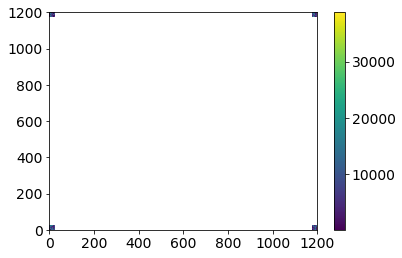

In [298]:
plt.pcolormesh(b)
plt.colorbar()

In [299]:
np.nanmean(a,axis=0)

array([492.44516208, 460.79504925, 335.3408954 , ..., 365.43088412,
       335.3408954 , 460.79504925])

In [300]:
np.nanmean(b,axis=0)

/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


array([13131.87098887, 12287.86797998,  8942.42387728, ...,
        9744.82357642,  8942.42387728, 12287.86797998])

In [ ]:
plt.plot()